# Import Required Libraries
Import the necessary libraries, including TensorFlow, NumPy, and Pandas.

In [1]:
# Import Required Libraries
import tensorflow as tf
import numpy as np
import pandas as pd

2024-11-28 15:38:54.148153: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 15:38:54.231135: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 15:38:54.308129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732826334.380604    4719 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732826334.402056    4719 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 15:38:54.569630: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Load and Preprocess Data
Load the stock price data, preprocess it by normalizing and creating sequences for training.

In [ ]:
from venv import create
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Load the stock price data
data = pd.read_csv('./merged_scaled_data (1).csv')
target = "Q avg to Q avg Price % Change"
# Normalize the data
new_data = data[["Period Ending",target]]
#drop nan values
#having the nan values in the rows affect the traiing as the loss can not be calcluated
#so we drop the rows with nan values
new_data = new_data.dropna()
data = data.dropna()
# Create sequences for training
def create_sequences(data, seq_length, target_column,exclude_columns=None):
    """
    Creates sequences of data for LSTM training.

    Args:
        data (pd.DataFrame): The dataframe containing features and target.
        seq_length (int): The number of timesteps in each sequence.
        target_column (str): The name of the target column.
        exclude_columns (list, optional): List of column names to exclude from features.

    Returns:
        np.array: Array of feature sequences.
        np.array: Array of target values.
    """
    x = []
    y = []
    for i in range(len(data) - seq_length):
        # Define the start and end indices for the sequence
        start_idx = i
        end_idx = i + seq_length

        # Select the sequence slice
        seq_slice = data.iloc[start_idx:end_idx]

        # Exclude specified columns and the target column
        if exclude_columns:
            feature_seq = seq_slice.drop(columns=exclude_columns).values
        else:
            feature_seq = seq_slice.drop(columns=[target_column]).values

        x.append(feature_seq)

        # Select the target value following the sequence
        target_val = data.iloc[end_idx][target_column]
        y.append(target_val)

    return np.array(x), np.array(y)
def create_sequences2(data, seq_length):
    x = []
    y = []
    if len(data) <= seq_length:
        raise ValueError("The length of features must be greater than the sequence length.")
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)
seq_length = 60
columns_to_drop = ["Ticker Symbol","Period Ending","Sector"]
data = data.drop(columns=columns_to_drop)
x, y = create_sequences(data, seq_length,target)
# x, y = create_sequences2(new_data, seq_length)
# x, y = create_sequences(new_data1,seq_length,target)

# Split the data into training and validation sets
split = int(0.8 * len(x))
x_train, x_val = x[:split], x[split:]
y_train, y_val = y[:split], y[split:]



     Period Ending  Q avg to Q avg Price % Change
0       2012-12-31                          19.96
1       2013-12-31                          47.15
2       2014-12-31                          18.72
3       2015-12-31                          -7.02
4       2012-12-29                           4.66
...            ...                            ...
1290    2014-12-31                           8.37
1291    2015-12-31                          -1.07
1292    2013-12-31                          -4.03
1293    2014-12-31                          11.26
1294    2015-12-31                          -5.76

[1289 rows x 2 columns]


In [16]:

# Check for NaN or Inf values
def check_nan_inf(array, name):
    print(f"\nChecking {name}:")
    print(f"Number of NaNs: {np.isnan(array).sum()}")
    print(f"Number of Infs: {np.isinf(array).sum()}")
print(x_train.dtype)  # Should be float32 or float64
print(y_train.dtype)  # Should be float32 or float64
print(x_val.dtype)
print(y_val.dtype)
print(x_train.shape)  # Should be (num_samples, seq_length, num_features)
check_nan_inf(x_train, "x_train")
check_nan_inf(y_train, "y_train")
check_nan_inf(x_val, "x_val")
check_nan_inf(y_val, "y_val")

float64
float64
float64
float64
(983, 60, 80)

Checking x_train:
Number of NaNs: 0
Number of Infs: 0

Checking y_train:
Number of NaNs: 0
Number of Infs: 0

Checking x_val:
Number of NaNs: 0
Number of Infs: 0

Checking y_val:
Number of NaNs: 0
Number of Infs: 0


# Build the LSTM Model
Define the LSTM model architecture using TensorFlow's Keras API.

In [ ]:
# Build the LSTM Model
units = 25
num_features = x_train.shape[2]
print(x_train.shape[1])
activation = 'tanh'
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=units, return_sequences=True, input_shape=(None, num_features)),
    tf.keras.layers.LSTM(units=units),
    tf.keras.layers.Dense(1,activation=activation)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
# Train the model
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
history = model.fit(
    x_train, 
    y_train, 
    epochs=20, 
    batch_size=64, 
    validation_data=(x_val, y_val))

# Evaluate the model
loss = model.evaluate(x_val, y_val)
print(f'Validation Loss: {loss}')

60


/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, None, 25)       │         2,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 25)             │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,826 (30.57 KB)

 Trainable params: 7,826 (30.57 KB)

 Non-trainable params: 0 (0.00 B)

(983, 60, 1)
(983,)
(246, 60, 1)
(246,)
Epoch 1/20


2024-11-28 15:41:26.903922: W tensorflow/core/framework/op_kernel.cc:1818] OP_REQUIRES failed at cast_op.cc:122 : UNIMPLEMENTED: Cast string to float is not supported


UnimplementedError: Graph execution error:

Detected at node sequential_3_1/Cast defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_4719/2903482361.py", line 19, in <module>

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/keras/src/models/sequential.py", line 213, in call

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/keras/src/models/functional.py", line 174, in call

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/keras/src/models/functional.py", line 280, in _standardize_inputs

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/keras/src/models/functional.py", line 238, in _convert_inputs_to_tensors

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/keras/src/ops/core.py", line 917, in convert_to_tensor

  File "/home/jacob/Documents/DS3000 Project/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/core.py", line 132, in convert_to_tensor

Cast string to float is not supported
	 [[{{node sequential_3_1/Cast}}]] [Op:__inference_one_step_on_iterator_14500]

# Compile and Train the Model
Compile the model with an appropriate optimizer and loss function, then train it on the preprocessed data.

In [ ]:
# Compile and Train the Model

# Compile the model with an appropriate optimizer and loss function
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the preprocessed data
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val))

# Evaluate the model
loss = model.evaluate(x_val, y_val)
print(f'Validation Loss: {loss}')

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 87.4442 - val_loss: 115.3047
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 77.4760 - val_loss: 115.9533
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 80.3249 - val_loss: 118.9237
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 86.0533 - val_loss: 118.1900
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 73.3640 - val_loss: 122.2611
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 85.6064 - val_loss: 119.1585
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 86.2060 - val_loss: 121.0695
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 87.8620 - val_loss: 125.4106
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 81.4597 - val_loss: 119.9997
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 71.9477 - val_loss: 123.1824
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 69.9270 - val_loss: 123.9074
Epoch 12/20
31/31 ━━━━━━━━━━━━

# Evaluate the Model
Evaluate the model's performance on a test dataset.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 126.6658
Validation Loss: 127.47993469238281
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Mean Squared Error: 8.440212935819858
R^2 Score: -0.11122665049276126


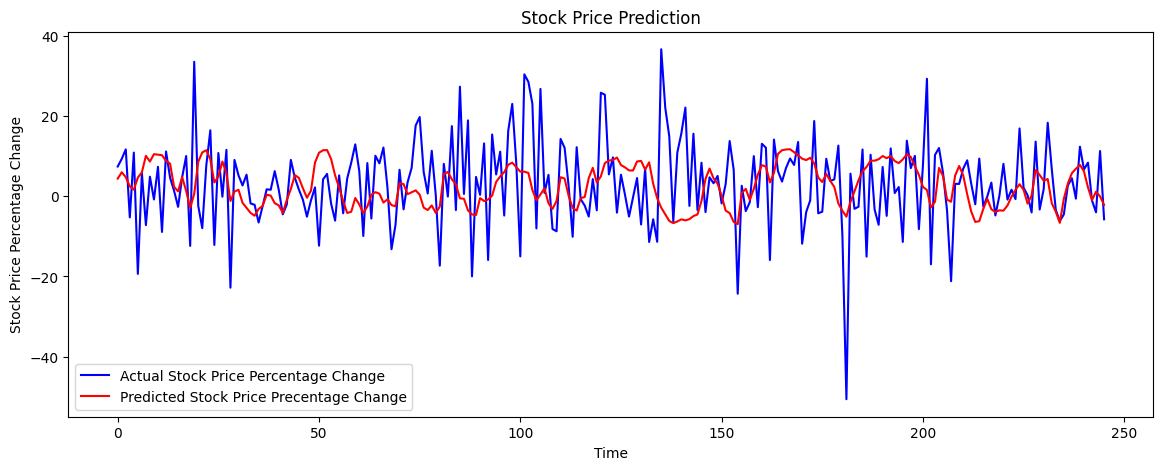

In [ ]:
# Evaluate the Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Evaluate the model's performance on the test dataset
loss = model.evaluate(x_val, y_val)
print(f'Validation Loss: {loss}')

# Make predictions on the validation set
predictions = model.predict(x_val)

# Inverse transform the predictions and actual values to get the original scale
actual = y_val.reshape(-1, 1)
mse_val = mean_absolute_error(actual, predictions)
print(f'Mean Squared Error: {mse_val}')
r2 = r2_score(actual, predictions)
print(f'R^2 Score: {r2}')

# Plot the predictions against the actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(actual, color='blue', label='Actual Stock Price Percentage Change')
plt.plot(predictions, color='red', label='Predicted Stock Price Precentage Change')
plt.title('Stock Price Prediction')
# time is the 250 differnt time stamps from 2012- 2016
plt.xlabel('Time')
plt.ylabel('Stock Price Percentage Change')
plt.legend()
plt.show()